In [147]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import re

def get_subpages(url):
    response = requests.get(url)
    html_content = response.content
    soup = BeautifulSoup(html_content, "html.parser")
    
    subpages = set()
    for year in range(2023, 2009, -1):
        for month in range(12, 0, -1):
            if (year == 2023 and month > 4) or (year == 2010 and month < 9) or year > 2023 or year < 2010:
                continue  # Skip this year-month combination
            subpage_url = f"{url}{str(year)}/{month:02d}/".replace("archives/", "")
            subpages.add(subpage_url)

    return subpages
      # Return the set of subpages

def get_article_links_and_dates(subpages):
    articles = {}
    links_set = set()
    for subpage in subpages:
        response = requests.get(subpage)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles_html = soup.find_all('article')
        for article_html in articles_html:
            link = article_html.find('a')['href']
            if link not in links_set:
                links_set.add(link)
                date_str = re.findall(r'/(\d{4})/(\d{2})/(\d{2})/', link)[0]
                date = "_".join(date_str)
                if date_str:
                    if date not in articles:
                        articles[date] = []
                    articles[date].append(link)

    return dict(sorted(articles.items(), key=lambda x: x[0], reverse=False))

In [148]:
import json
sub_pages = get_subpages("https://www.excal.on.ca/archives/")

# Call the function to get the scraped data
scraped_data = get_article_links_and_dates(sub_pages)

# Open a new file for writing and save the scraped data to it
with open('york_article_pages.json', 'w') as outfile:
        json.dump(scraped_data, outfile, indent=4)


In [156]:
from helpers.txt_to_text import get_article_text
from helpers.make_txt_entry import make_txt_entry
import os

school_name = "York"
dates = sorted(scraped_data.keys())

for date in reversed(dates):
    articles = scraped_data[date]
    file_path = "journal_data/txt/"+school_name.replace(" ","_")+"/"+date+".txt"
    if(os.path.exists(file_path)):
        print(f"Date {date} already added.")
    else:
        article_text = ""
        for article in articles:
            article_text += get_article_text(article) + "\n"
            
        make_txt_entry(school_name="York", publication_date=date, text=article_text)
        print(f"Date {date} added.")

Date 2023_04_26 added.
Date 2023_04_24 added.
Date 2023_04_22 added.
Date 2023_04_21 added.
Date 2023_04_07 added.
Date 2023_04_06 added.
Date 2023_04_04 added.
Date 2023_04_03 added.
Date 2023_03_31 added.
Date 2023_03_29 added.
Date 2023_03_27 added.
Date 2023_03_24 added.
Date 2023_03_23 added.
Date 2023_03_22 added.
Date 2023_03_21 added.
Date 2023_02_28 added.
Date 2023_02_27 added.
Date 2023_02_17 added.
Date 2023_02_13 added.
Date 2023_02_10 added.
Date 2023_02_09 added.
Date 2023_02_08 added.
Date 2023_02_07 added.
Date 2023_01_31 added.
Date 2023_01_30 added.
Date 2023_01_27 added.
Date 2023_01_24 added.
Date 2023_01_19 added.
Date 2023_01_18 added.
Date 2022_12_05 added.
Date 2022_11_29 added.
Date 2022_11_23 added.
Date 2022_11_15 added.
Date 2022_11_14 added.
Date 2022_11_11 added.
Date 2022_11_10 added.
Date 2022_11_08 added.
Date 2022_11_04 added.
Date 2022_10_31 added.
Date 2022_10_28 added.
Date 2022_10_27 added.
Date 2022_10_26 added.
Date 2022_10_25 added.
Date 2022_1

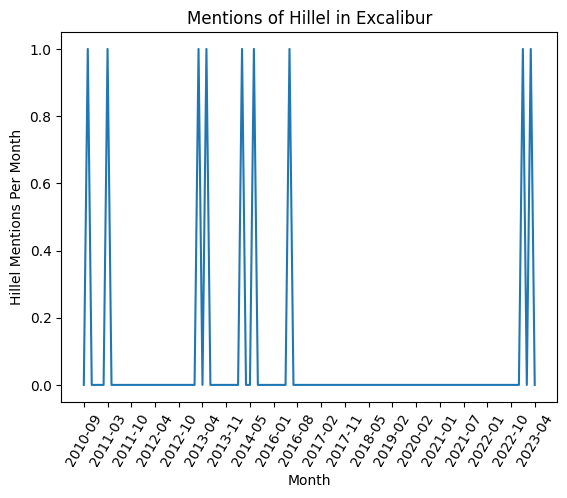

In [158]:
from helpers.graphers import monthly_grapher
from helpers.queries import hillel_counter

school_name = "York"
newspaper_name = "Excalibur"
school_name_lower = school_name.lower()

York_pipeline = []

directory = 'journal_data/txt/' + school_name

monthly_grapher(directory=directory,
                pipeline=York_pipeline,
                query=hillel_counter,
                y_label="Hillel Mentions Per Month",
                title="Mentions of Hillel in " + newspaper_name,
                save_path='figures/' + school_name + '/' + school_name + '_hillel_mentions.png')
